# PR101: Effect of KD of CYTB and ND2 on the mitochondrial proteome
The samples are purified mitochondria from HEK293T cells with either Cytochrome B knockdown, ND2 knockdown or a wild-type control. Cells are unlabelled and comparison of protein abundances has to be done solely on LFQ basis.

## Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

pd.set_option("display.max_columns", None)

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.20'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

In [2]:
# load protein groups
pg_raw = pp.read_csv("../maxquant/txt/proteinGroups.txt")
pg_raw = pp.cleaning(pg_raw, file="proteinGroups")
pg = pg_raw.copy()

2543 rows before filter operation.
2480 rows after filter operation.


In [3]:
# load peptides
peps = pp.read_csv("../maxquant/txt/peptides.txt")
peps = pp.cleaning(peps, file="peptides.txt")

12076 rows before filter operation.
12076 rows after filter operation.


In [4]:
# We need the gene names for plot annotation later
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

We will rely on MaxQuant LFQ values since these inherently normalise the ratios between the conditions. The justification for this is the assumption that most protein abundances in the mitochondria will not change if we knock down important parts of the respiratory chain.

In [5]:
intens = pg.filter(regex="LFQ intensity").columns.tolist()
# replace zero intens with NAN
pg[intens] = pg[intens].replace(0, np.nan)

True

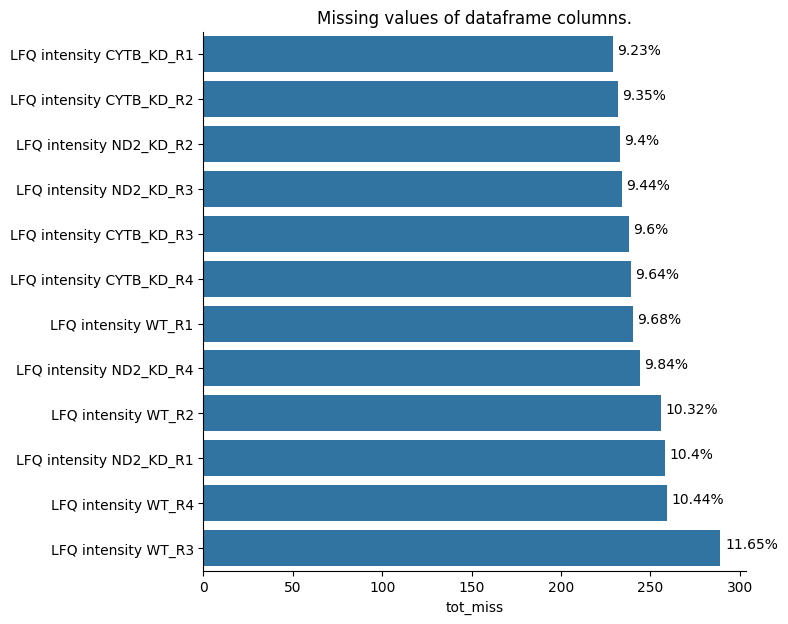

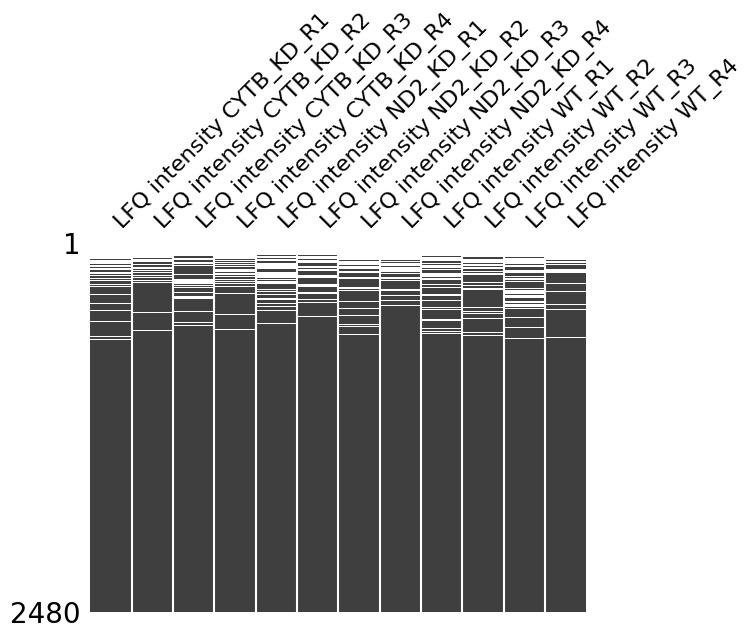

In [6]:
ana.miss_analysis(pg, intens, text=False, extra_vis=True)

### Missing values
With up to 11% missing values between conditions, the samples appear rather reproducible in this data set.

In [7]:
# nested list of column names for downstream accessing
intens_nested = [
    pg.filter(regex="LFQ intensity WT").columns.tolist(),
    pg.filter(regex="LFQ intensity CYTB").columns.tolist(),
    pg.filter(regex="LFQ intensity ND2").columns.tolist(),
]
intens_nested

[['LFQ intensity WT_R1',
  'LFQ intensity WT_R2',
  'LFQ intensity WT_R3',
  'LFQ intensity WT_R4'],
 ['LFQ intensity CYTB_KD_R1',
  'LFQ intensity CYTB_KD_R2',
  'LFQ intensity CYTB_KD_R3',
  'LFQ intensity CYTB_KD_R4'],
 ['LFQ intensity ND2_KD_R1',
  'LFQ intensity ND2_KD_R2',
  'LFQ intensity ND2_KD_R3',
  'LFQ intensity ND2_KD_R4']]

### Filtering
We filter so that each protein group contains LFQ intensities for et least 75% of the conditions. Since the search was done with MBR enabled, this is a rather liberal filtering.

In [8]:
pg = pp.filter_vv(pg, intens_nested, 3)

2480 rows before filter operation.
2113 rows after filter operation.


In [9]:
pg, log_intens = pp.log(pg, intens, return_cols=True)
log_intens

['log2_LFQ intensity CYTB_KD_R1',
 'log2_LFQ intensity CYTB_KD_R2',
 'log2_LFQ intensity CYTB_KD_R3',
 'log2_LFQ intensity CYTB_KD_R4',
 'log2_LFQ intensity ND2_KD_R1',
 'log2_LFQ intensity ND2_KD_R2',
 'log2_LFQ intensity ND2_KD_R3',
 'log2_LFQ intensity ND2_KD_R4',
 'log2_LFQ intensity WT_R1',
 'log2_LFQ intensity WT_R2',
 'log2_LFQ intensity WT_R3',
 'log2_LFQ intensity WT_R4']

## Imputation and normalisation
The remaining >= 2 missing values are imputed with sequential imputation to gain ratios under all conditions. 
Additionally, cyclic LOESS normalisation is done within each condition group (i.e. CYTB KD vs. ND2 KD vs. WT).

In [10]:
pg, intens_imp = pp.imp_seq(pg, log_intens, return_cols=True)
intens_imp.remove("UID")

In [11]:
intens_norm = []
for cond in [intens_imp[:4], intens_imp[4:8], intens_imp[8:12]]:
    pg, i = pp.cyclic_loess(pg, cond, return_cols=True)
    intens_norm.extend(i)

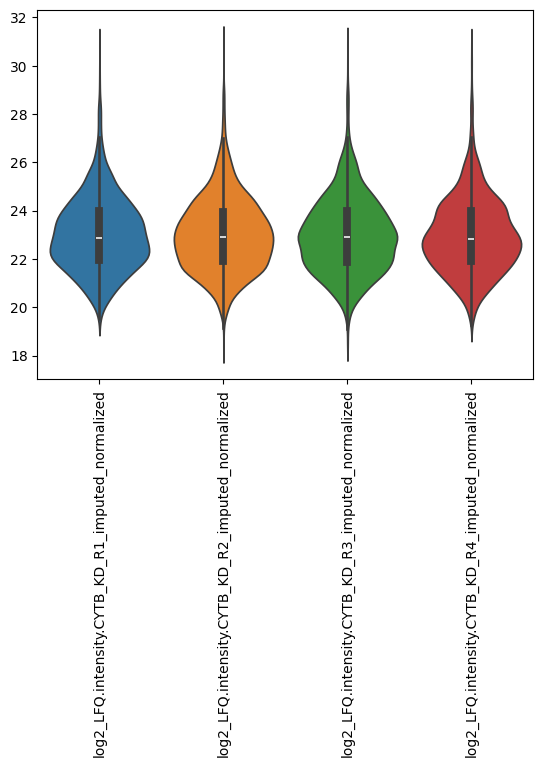

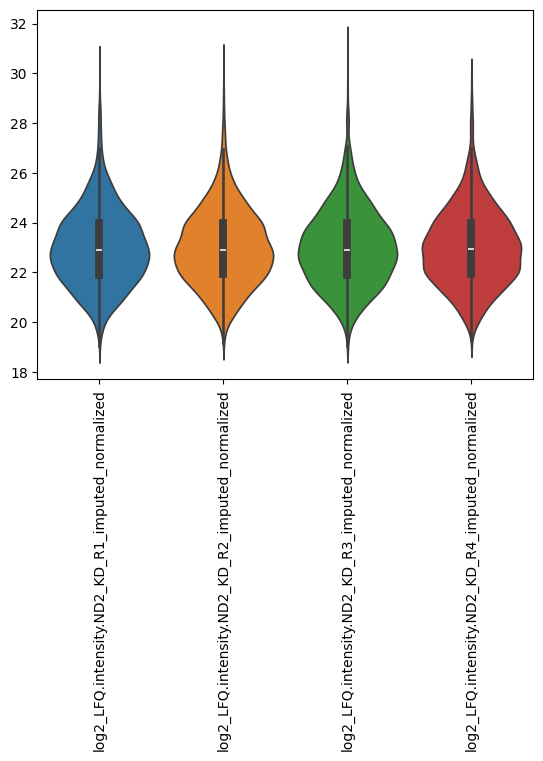

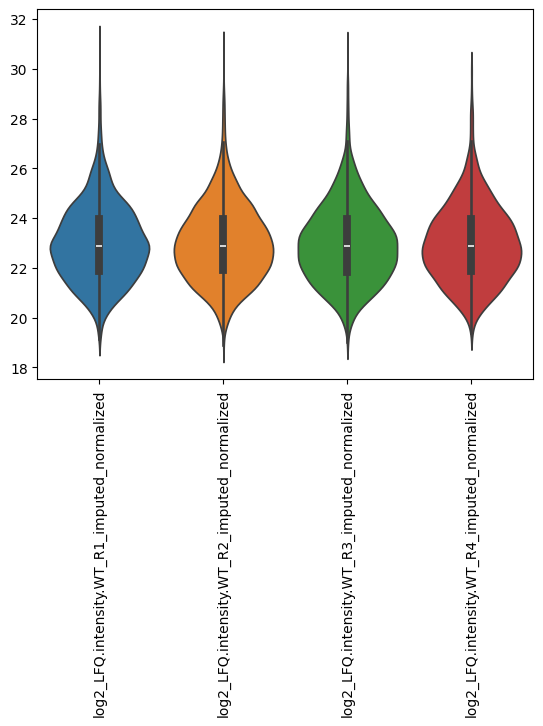

In [12]:
# boxplot for replicate comparison
for cond in [intens_norm[:4], intens_norm[4:8], intens_norm[8:12]]:
    sns.violinplot(pg[cond])
    plt.xticks(rotation=90)
    plt.show()

## Ratio calculation
We will calculate the ratios manually for generating ratio/intensity plots. As we will also perform 2-smaple statistical analysis, these ratios will also be calculated by the underlaying stats modules.

In [13]:
# calculate the ratios
wt_cond = intens_norm[8:12]

print(wt_cond)

for cond in [intens_norm[:4], intens_norm[4:8]]:
    pg[
        [
            f'Ratio {cond[0].split("_KD_")[0].split(".")[-1]} vs. WT Rep{i+1}'
            for i in range(4)
        ]
    ] = (pg[cond].values / pg[wt_cond].values)

['log2_LFQ.intensity.WT_R1_imputed_normalized', 'log2_LFQ.intensity.WT_R2_imputed_normalized', 'log2_LFQ.intensity.WT_R3_imputed_normalized', 'log2_LFQ.intensity.WT_R4_imputed_normalized']


### Ratio/Intensity per replicate
Calculating ratio/intensity plots for all raw data points allows to get an overview on the data. Here we can already see that there is not much spread in the distribution, i.e. most of the protein abundances appear unchanged.

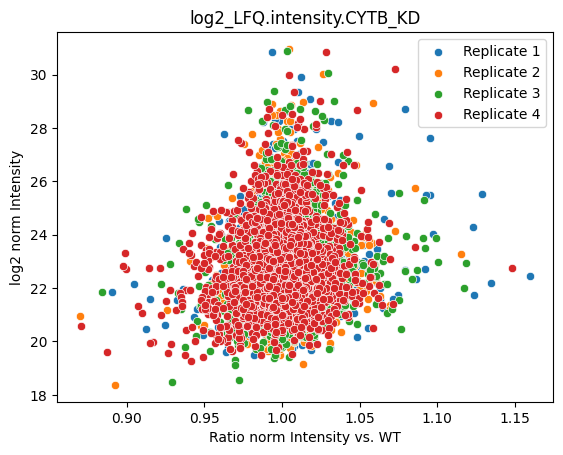

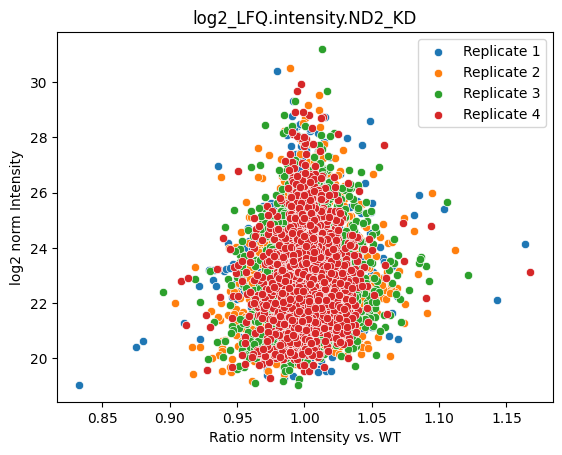

In [14]:
# ratio intensity plots
for cond in [intens_norm[:4], intens_norm[4:8]]:
    ratio = pg.filter(regex=f'Ratio {cond[0].split("_KD_")[0].split(".")[-1]}').values
    intens = pg[cond].values
    for i, (rep_ratio, rep_intens) in enumerate(zip(ratio.T, intens.T)):
        sns.scatterplot(x=rep_ratio, y=rep_intens, label=f"Replicate {i+1}")
    plt.ylabel("log2 norm Intensity")
    plt.xlabel("Ratio norm Intensity vs. WT")
    plt.title(cond[0].split("R1")[0][:-1])
    plt.savefig(f"PR101_{cond[0].split('R1')[0][:-1]}_ratio_intens.pdf")
    plt.show()

### Ratio/intensity per protein group
Using the same approach per protein group (and including the variance within each group as point size) leads to a similar picture. Strongest depletion is a log2 ratio of -0.1 (i.e. 0.93 in non-log-space).

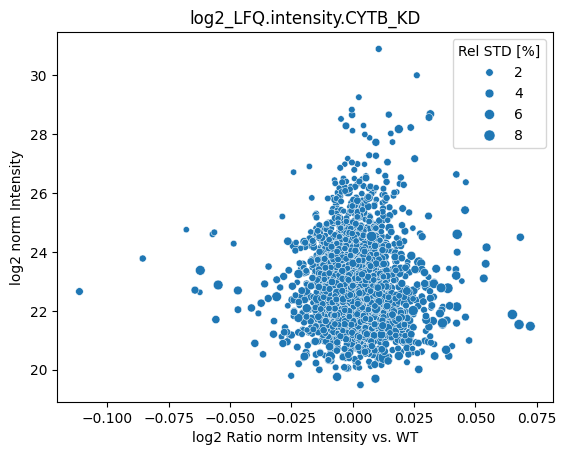

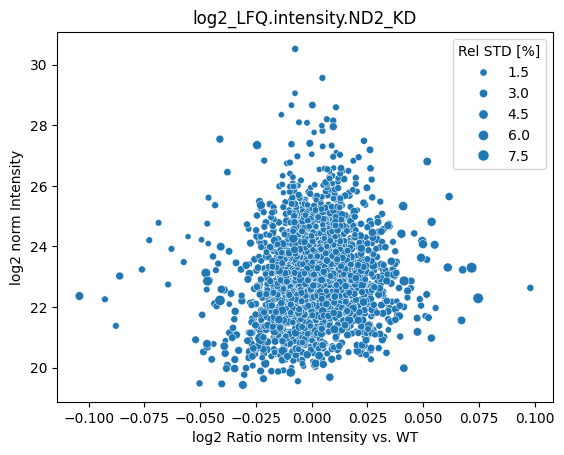

In [15]:
# ratio intensity plots
for cond in [intens_norm[:4], intens_norm[4:8]]:
    ratio = pg.filter(regex=f'Ratio {cond[0].split("_KD_")[0].split(".")[-1]}').values
    mean_ratio = np.mean(ratio, axis=1)
    std_ratio = np.std(ratio, axis=1)
    std_ratio = 100 * std_ratio / mean_ratio
    mean_ratio = np.log2(mean_ratio)
    intens = pg[cond].mean(axis=1).values
    ax = sns.scatterplot(x=mean_ratio, y=intens, size=std_ratio)
    ax.legend(title="Rel STD [%]")
    plt.ylabel("log2 norm Intensity")
    plt.xlabel("log2 Ratio norm Intensity vs. WT")
    plt.title(cond[0].split("R1")[0][:-1])
    plt.savefig(f"PR101_{cond[0].split('R1')[0][:-1]}_mean_ratio_intens.pdf")
    plt.show()

## PCA analysis
To check if the different treatment conditions are reflected in the data, a principal component analysis is performed. As we previously normalised within each treatment group, already this normalistion should bias towards separation in the experiment groups. However, no clear separation of the underlying experiment can be seen - neither on the raw LFQ intensity level nor on the basis of the manually calculated intensity ratios.

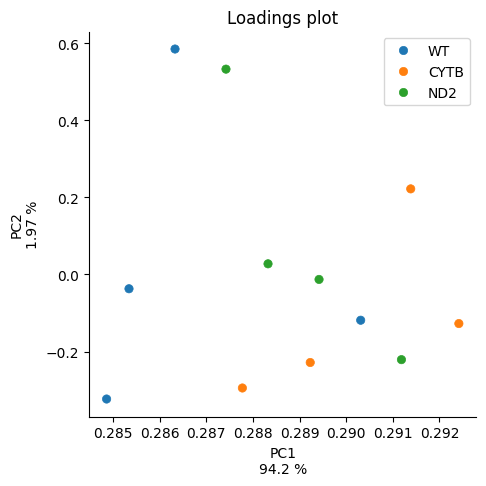

In [16]:
pca = ana.AutoPCA(
    dataframe=pg[intens_norm],
    clabels=intens_norm,
    batch=[
        "WT",
        "WT",
        "WT",
        "WT",
        "CYTB",
        "CYTB",
        "CYTB",
        "CYTB",
        "ND2",
        "ND2",
        "ND2",
        "ND2",
    ],
)

pca.loading_plot(labeling=False)

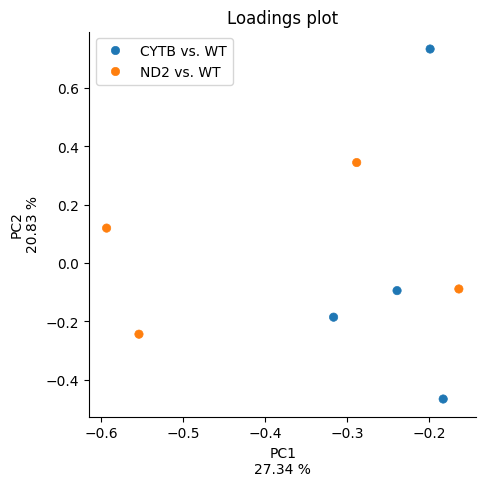

In [17]:
ratios = pg.filter(regex="Ratio").columns
pca = ana.AutoPCA(
    dataframe=pg[ratios],
    clabels=ratios,
    batch=[
        "CYTB vs. WT",
        "CYTB vs. WT",
        "CYTB vs. WT",
        "CYTB vs. WT",
        "ND2 vs. WT",
        "ND2 vs. WT",
        "ND2 vs. WT",
        "ND2 vs. WT",
    ],
)

pca.loading_plot(labeling=False)

## Checking the effect of the knockdown
Since the data look so indifferent, we check here if the underlying treatment (i.e. the knockdown) can be seen in it. Therefore, we plot the ratios for each knocked-down protein (group) and check if is different from 1.

['MT-CO1;COX1;COI;coxI;CO1;RHO']


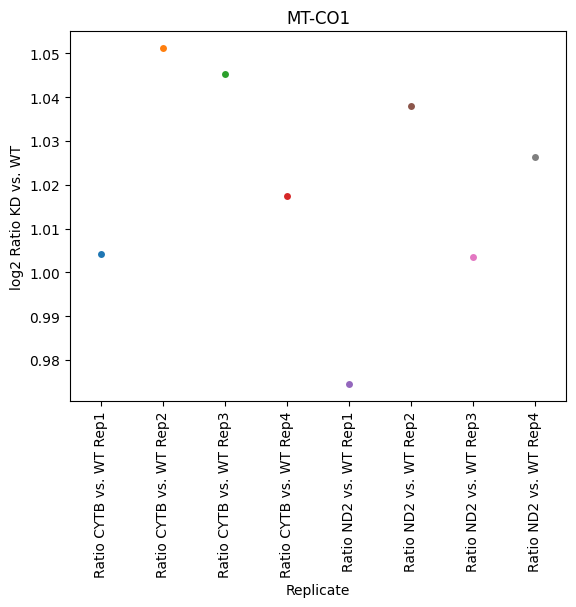

[]


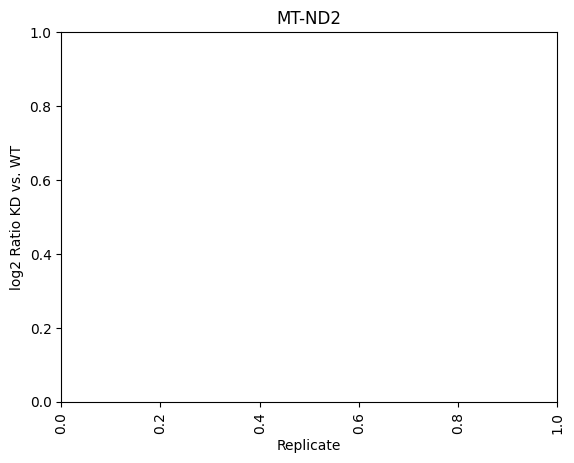

In [18]:
for gene, kd in zip(["MT-CO1", "MT-ND2"], ["CYTB", "ND2"]):
    tmp = pg[pg["Gene names"].str.contains(gene, na=False)]

    print(tmp["Gene names"].tolist())

    sns.stripplot(tmp.filter(regex="Ratio"))
    plt.title(gene)
    plt.xticks(rotation=90)
    plt.xlabel("Replicate")
    plt.ylabel("log2 Ratio KD vs. WT")
    plt.savefig(f"PR101_per_rep_ratio_{gene}.pdf")
    plt.show()

,Intensity WT_R1,Intensity WT_R2,Intensity WT_R3,Intensity WT_R4
1175,NaN,NaN,564160,871500.0


,Intensity CYTB_KD_R1,Intensity CYTB_KD_R2,Intensity CYTB_KD_R3,Intensity CYTB_KD_R4
1175,NaN,2313100.0,1243900.0,705680


Peptide matches to 6 genes: ['MT-CO1', 'COX1', 'COI', 'coxI', 'CO1', 'RHO']


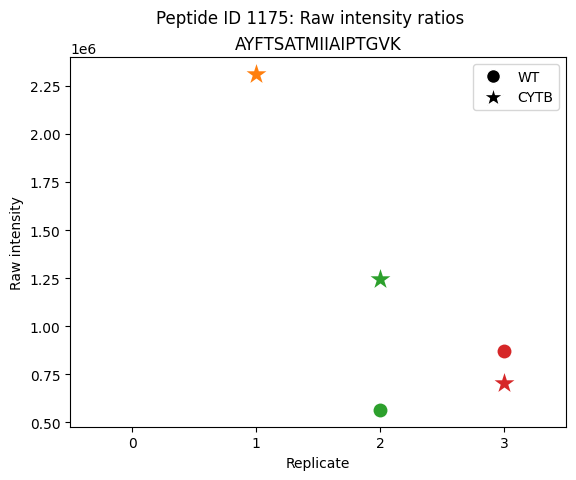

,Intensity WT_R1,Intensity WT_R2,Intensity WT_R3,Intensity WT_R4
10994,NaN,1877100.0,NaN,NaN


,Intensity CYTB_KD_R1,Intensity CYTB_KD_R2,Intensity CYTB_KD_R3,Intensity CYTB_KD_R4
10994,2124300.0,5675000.0,5121700.0,NaN


Peptide matches to 5 genes: ['MT-CO1', 'COX1', 'COI', 'coxI', 'CO1']


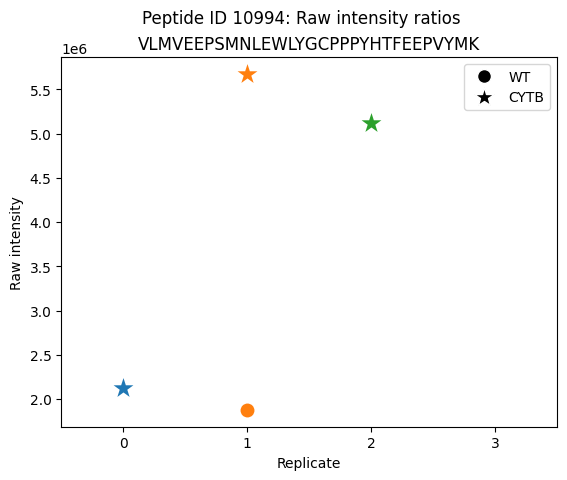

,Intensity WT_R1,Intensity WT_R2,Intensity WT_R3,Intensity WT_R4
11530,11099000.0,3705100.0,2167900,18586000.0


,Intensity CYTB_KD_R1,Intensity CYTB_KD_R2,Intensity CYTB_KD_R3,Intensity CYTB_KD_R4
11530,14573000.0,8818600.0,12431000.0,4657500


Peptide matches to 7 genes: ['MT-CO1', 'COX1', 'COI', 'coxI', 'CO1', 'RHO', 'cox1']


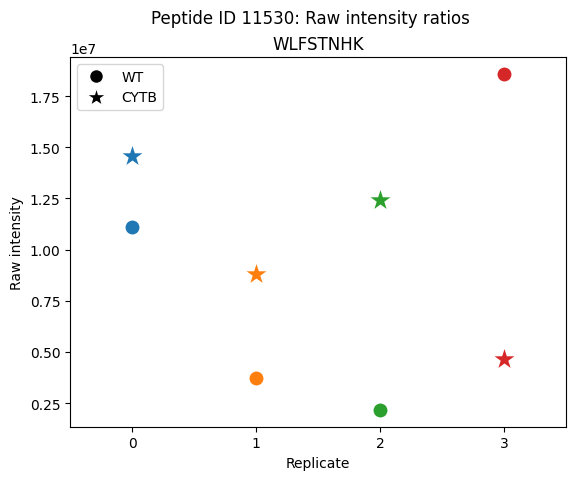

In [19]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D

peptide_ids = (
    pg.loc[pg["Gene names"].str.contains("MT-CO1", na=False), "Peptide IDs"]
    .str.split(";")
    .tolist()[0]
)

# Open a PDF to save the plots
with PdfPages("PR101_CYTB_intensity_per_pep.pdf") as pdf:
    for pep_id in peptide_ids:
        tmp = peps[peps["id"] == int(pep_id)]

        intens_cytb = tmp.filter(regex="Intensity CYTB").replace(0, np.nan)
        intens_nd2 = tmp.filter(regex="Intensity ND2").replace(0, np.nan)
        intens_wt = tmp.filter(regex="Intensity WT").replace(0, np.nan)

        display(intens_wt)
        display(intens_cytb)
        sequence = tmp["Sequence"].tolist()[0]
        print(
            f"Peptide matches to {len(tmp['Gene names'].str.split(';').values[0])} genes: {tmp['Gene names'].str.split(';').values[0]}"
        )

        fig, ax = plt.subplots(1)

        sns.stripplot(intens_cytb.values, ax=ax, marker="*", s=15)
        sns.stripplot(intens_wt.values, ax=ax, marker="o", s=10)

        # Manually create the legend
        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor="k",
                markersize=10,
                label="WT",
            ),
            Line2D(
                [0],
                [0],
                marker="*",
                color="w",
                markerfacecolor="k",
                markersize=15,
                label="CYTB",
            ),
        ]

        # Add the legend to the plot
        plt.legend(handles=legend_elements)

        plt.suptitle(f"Peptide ID {pep_id}: Raw intensity ratios")
        plt.title(sequence)
        plt.ylabel("Raw intensity")
        plt.xlabel("Replicate")

        # Save the current figure to the PDF
        pdf.savefig(fig)
        plt.show()
        plt.close(fig)  # Close the figure to avoid too many open figures

## Statistical Analysis
Despite the lack of clear effects in the previous plots, we still perform statistical analyses. The reference plot in the paper was done with 2-sample ttest. However, to gain more sensitivity by using (effect size invariant) rank analysis, we start with a rank product test.

In [20]:
pg = ana.rank_prod(
    pg,
    [
        ["log2_" + x + "_imputed" for x in intens_nested[1]],
        ["log2_" + x + "_imputed" for x in intens_nested[0]],
    ],
    cond="_CYTBvsWT",
)

pg = ana.rank_prod(
    pg,
    [
        ["log2_" + x + "_imputed" for x in intens_nested[2]],
        ["log2_" + x + "_imputed" for x in intens_nested[0]],
    ],
    cond="_ND2vsWT",
)

rankProd: Assuming a two sample test with:
Sample 1: 
	log2_LFQ intensity CYTB_KD_R1_imputed, 
	log2_LFQ intensity CYTB_KD_R2_imputed, 
	log2_LFQ intensity CYTB_KD_R3_imputed, 
	log2_LFQ intensity CYTB_KD_R4_imputed
Sample 2: 
	log2_LFQ intensity WT_R1_imputed, 
	log2_LFQ intensity WT_R2_imputed, 
	log2_LFQ intensity WT_R3_imputed, 
	log2_LFQ intensity WT_R4_imputed
Class labels: 0, 0, 0, 0, 1, 1, 1, 1
rankProd: Assuming a two sample test with:
Sample 1: 
	log2_LFQ intensity ND2_KD_R1_imputed, 
	log2_LFQ intensity ND2_KD_R2_imputed, 
	log2_LFQ intensity ND2_KD_R3_imputed, 
	log2_LFQ intensity ND2_KD_R4_imputed
Sample 2: 
	log2_LFQ intensity WT_R1_imputed, 
	log2_LFQ intensity WT_R2_imputed, 
	log2_LFQ intensity WT_R3_imputed, 
	log2_LFQ intensity WT_R4_imputed
Class labels: 0, 0, 0, 0, 1, 1, 1, 1


In [21]:
pg = ana.ttest(
    pg,
    [
        ["log2_" + x + "_imputed" for x in intens_nested[1]],
        ["log2_" + x + "_imputed" for x in intens_nested[0]],
    ],
    cond="_CYTBvsWT_tt2samp",
)

pg = ana.ttest(
    pg,
    [
        ["log2_" + x + "_imputed" for x in intens_nested[2]],
        ["log2_" + x + "_imputed" for x in intens_nested[0]],
    ],
    cond="_ND2vsWT_tt2samp",
)

Performing two-sample t-Test
Performing two-sample t-Test


In [22]:
# log2 of ratios
pg = pp.log(pg, pg.filter(regex="Ratio").columns)

pg = ana.ttest(
    pg,
    pg.filter(regex="log2_Ratio CYT").columns,
    cond="_CYTBvsWT_tt1samp",
)

pg = ana.ttest(
    pg,
    pg.filter(regex="log2_Ratio ND2").columns,
    cond="_ND2vsWT_tt1samp",
)

Performing one-sample t-Test
Performing one-sample t-Test


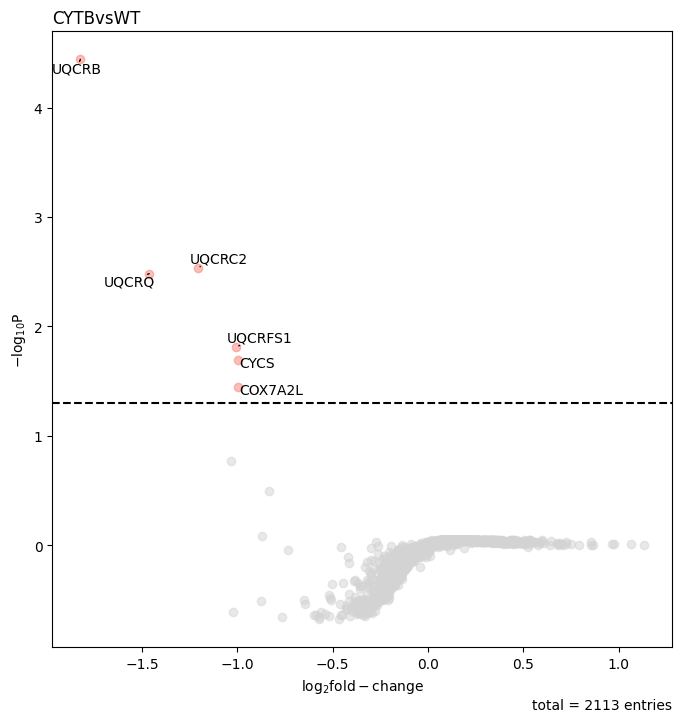

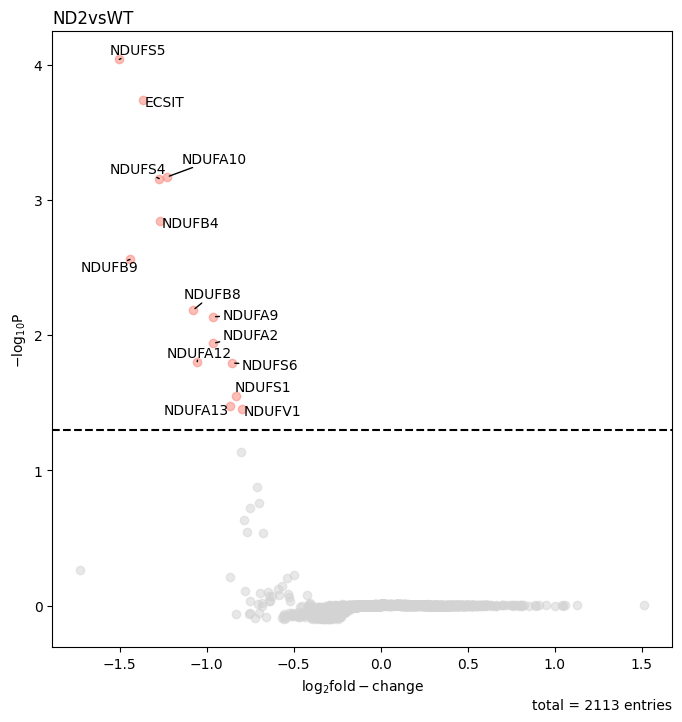

In [23]:
for cond in ["_CYTBvsWT", "_ND2vsWT"]:
    vis.volcano(
        pg,
        log_fc_colname="logFC" + cond,
        p_colname="adj.P.Val_class1<class2" + cond,
        annotate_colname="Gene names first",
        log_fc_thresh=None,
        annotate="p-value",
        kwargs_p_sig={"color": "salmon"},
        show_legend=False,
        title=cond[1:],
    )

    plt.savefig(f"PR101_volcano_rankprod{cond}.pdf")

Not enough data points for KDE. Return original point cloud.
Not enough data points for KDE. Return original point cloud.


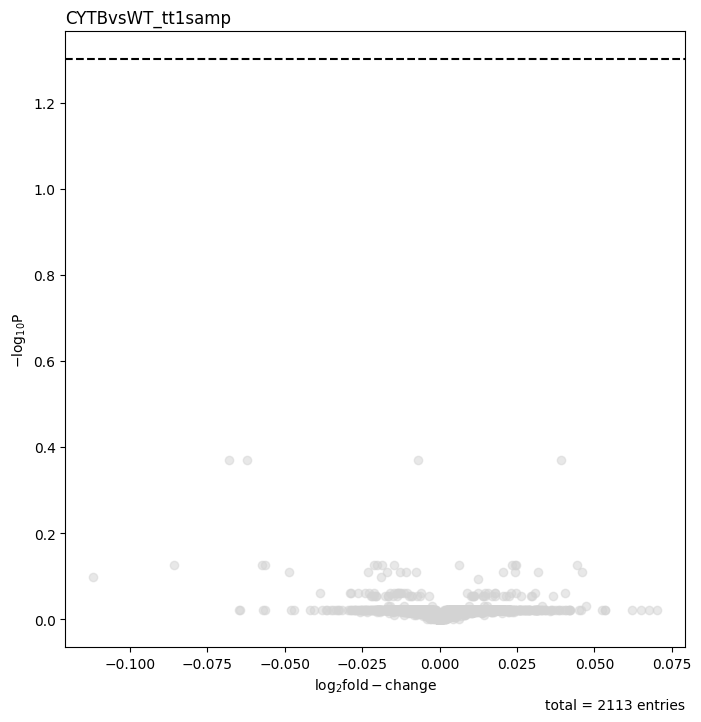

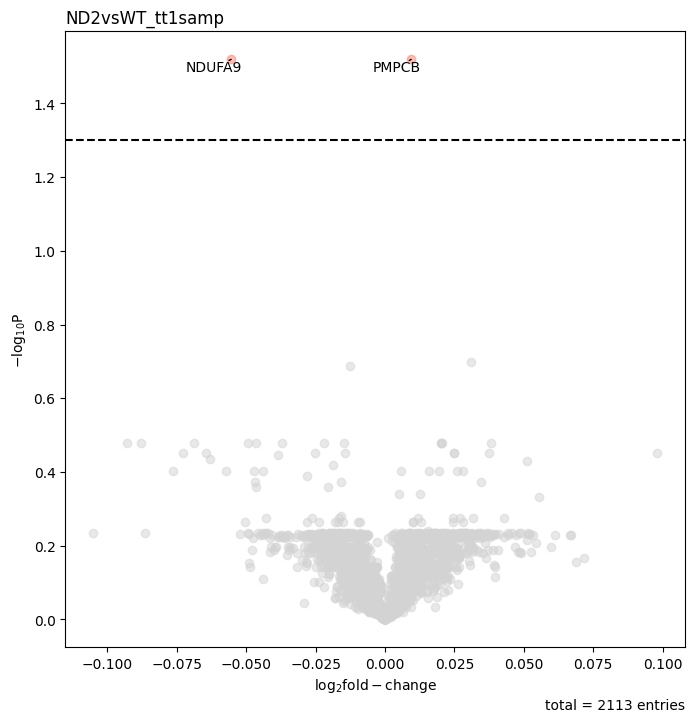

In [24]:
for cond in ["_CYTBvsWT_tt1samp", "_ND2vsWT_tt1samp"]:
    vis.volcano(
        pg,
        log_fc_colname="logFC" + cond,
        p_colname="adj.pValue" + cond,
        annotate_colname="Gene names first",
        log_fc_thresh=None,
        annotate="p-value",
        kwargs_p_sig={"color": "salmon"},
        show_legend=False,
        title=cond[1:],
    )

    plt.savefig(f"PR101_volcano_ttest{cond}.pdf")

Not enough data points for KDE. Return original point cloud.


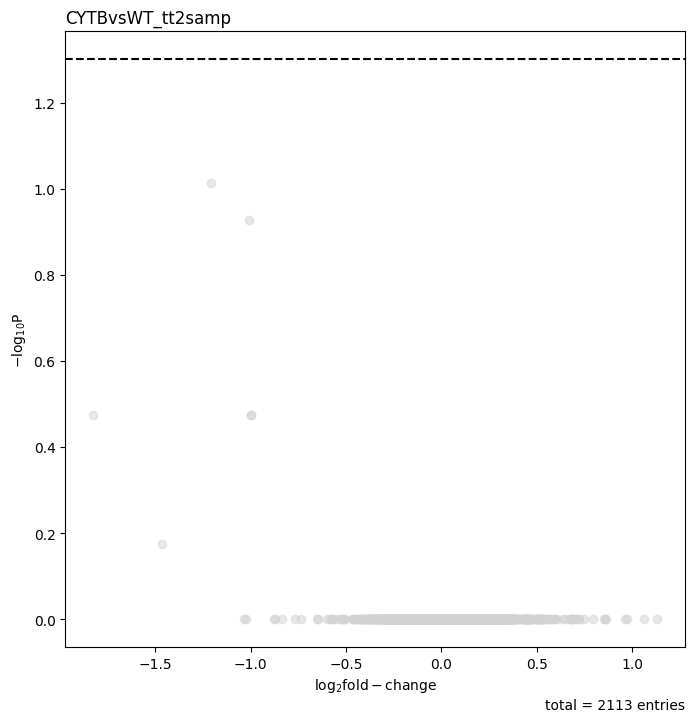

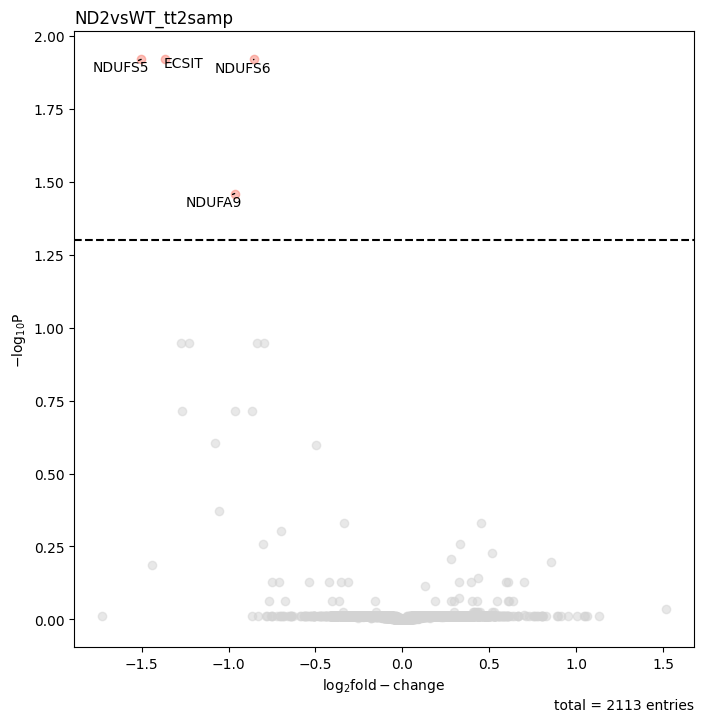

In [25]:
for cond in ["_CYTBvsWT_tt2samp", "_ND2vsWT_tt2samp"]:
    vis.volcano(
        pg,
        log_fc_colname="logFC" + cond,
        p_colname="adj.pValue" + cond,
        annotate_colname="Gene names first",
        log_fc_thresh=None,
        annotate="p-value",
        kwargs_p_sig={"color": "salmon"},
        show_legend=False,
        title=cond[1:],
    )

    plt.savefig(f"PR101_volcano_ttest{cond}.pdf")

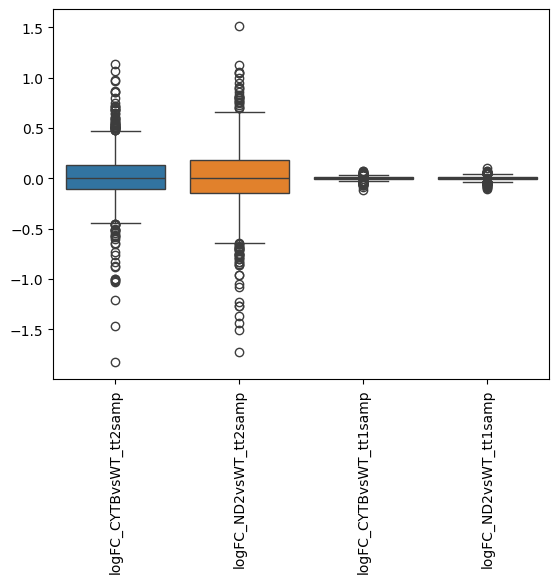

In [26]:
sns.boxplot(pg.filter(regex="logFC.*_tt"))
plt.xticks(rotation=90)

plt.show()